The following is my capstone project for the Thinkful Data Science Prep Course. 

The dataset used is the full downloadable dataset from Rob Volman's yearly 'Hockey Abstract' which contains around 350 tracked stats for all 898 athletes who played in the NHL in any given year. The dataset contains traditional hockey stats like Games Played(GP), PIM(Penalties in minutes), Goals, Assists, etc. as well as some of the more advanced stats like Corsi and Fenwick. There are also a few non-traditional stats either of Rob and his colleague's own devising(Grit) and basic information about each player such as height, weight, draft number and more.

I have decided to limit the data to only players who appeared in 10 or more NHL games. I believe this makes the data more representative of actual NHL players since it would filter out a team's prospects who might get called up for 1 or 2 games as a tryout before being sent back down to the minors where they will spend the majority of the season.

In [1]:
import sqlite3
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
%matplotlib inline
cnx = sqlite3.connect('/users/krisstenglein/Desktop/Hockey Capstone DB.db')

In [32]:
# This dataframe contains averaged data from all players grouped by their respective teams
df_teams = pd.read_sql_query("Select EndTeam, Avg(HT) as 'Height', Avg(WT) as 'Weight', Sum(HitA) as 'Hit A', Sum(HitF) as 'Hit F' from 'Main Page' Where GP >=10 Group By EndTeam Order By Avg(HT) DESC", cnx)
df_teams.head()

,EndTeam,Height,Weight,Hit A,Hit F
0,WPG,74.043478,205.391304,1552,1924
1,LAK,73.958333,209.833333,2282,2551
2,COL,73.840000,208.320000,1686,1941
3,CGY,73.826087,200.391304,1228,1536
4,EDM,73.733333,205.566667,2025,1973


In [34]:
# This dataframe contains straight player data based on the SQL criteria listed in the call
df_players = pd.read_sql_query("Select HT, WT, HitA, HitF from 'Main Page' Where GP >= 10 Order By HT", cnx)
df_players.head()

,HT,Wt,HitA,HitF
0,65,178,25,54
1,66,180,23,17
2,67,174,76,31
3,67,178,75,46
4,67,175,89,113


In [35]:
# This small dataframe contains groupings of players by height as well as the average hits for and against for that height group
df_play_HT = pd.read_sql_query("Select HT, Avg(HitF) as 'Hit F', Avg(HitA) as 'Hit A' from 'Main Page' Where GP >= 10 Group by HT", cnx)
df_play_HT.head()

,HT,Hit F,Hit A
0,65,54.0,25.0000
1,66,17.0,23.0000
2,67,69.5,78.2500
3,68,48.4,43.6000
4,69,39.0,55.5625


My first analytical question is about hitting in the NHL. I have 4 stats; height, weight, hits against and hits for for each player in the league. The first thing I want to explore is the relationship between team size and hitting. Every fan knows the traditionally more physical teams around the league(Philly, Nashville, St. Louise, etc), but are they also the biggest?

Questions:

    A) Is there a relationship between team size and hits? Do bigger teams hit more and do  smaller teams get hit more?
    B) Is there a similar trend at the player level?
   

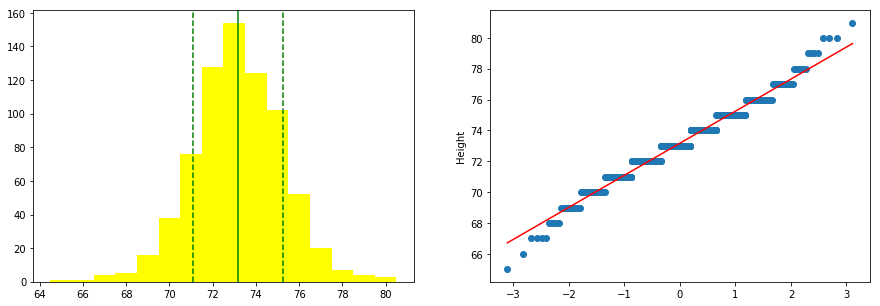

In [5]:
plt.figure(figsize = (15,5))
plt.subplot(1,2,1)
plt.hist(df_players['HT'], bins = np.arange(64.5,81.5),color = 'yellow')
plt.axvline(df_players['HT'].mean(), color = 'green')
plt.axvline(df_players['HT'].mean() + df_players['HT'].std(), color = 'green', linestyle = 'dashed')
plt.axvline(df_players['HT'].mean() - df_players['HT'].std(), color = 'green', linestyle = 'dashed')

plt.subplot(1,2,2)
(osm, osr), (slope, intercept, r) = stats.probplot(df_players['HT'])
plt.scatter(osm, osr)
x = np.array([osm.min(), osm.max()])
y = slope*x + intercept
plt.plot(x,y, color = 'r')
plt.ylabel('Height')
plt.show()

Using a histogram and a modified QQ plot it is clear that the player height is normall distributed.

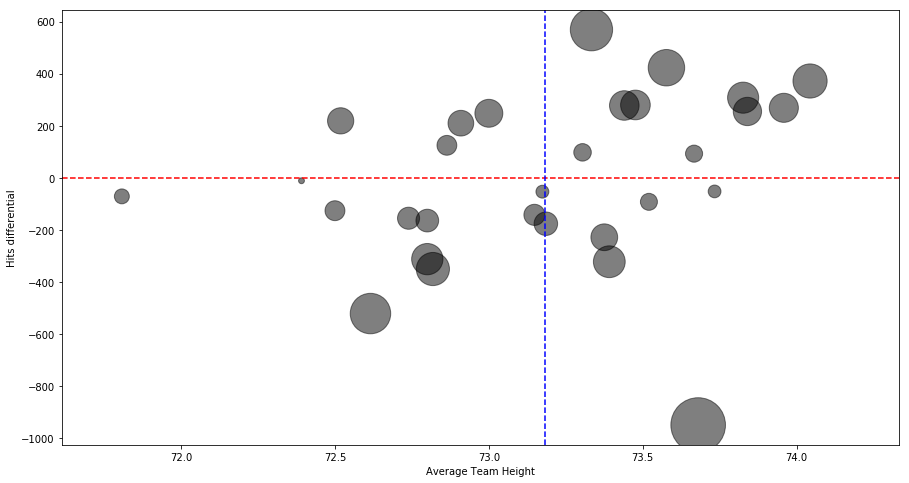

In [24]:
# Comparing average team height to hit differential
plt.figure(figsize = (15,8))
plt.axhline(0, color = 'r', linestyle = '--')
plt.axvline(df_teams['Height'].mean(), color = 'b', linestyle = '--')
hit_diff = (df_teams['Hit F']-df_teams['Hit A'])
plt.xlabel('Average Team Height')
plt.ylabel('Hits differential')
area = np.pi * np.sqrt(hit_diff**2)
plt.scatter(df_teams['Height'], hit_diff, s = area, alpha = .5, c = 'k')
plt.show()

This graph shows a teams hit differential with the red line being 0 difference between hits thrown and hit received and the blue line representing the mean of the team heights. The larger the circle the bigger the difference with the placement of the circle indicating the overal hit differential. 

If the outlier at the very bottom of the graph(Chicago Blackhawks) were removed there would be a much clearer trend of hit differential to size apparent in the data.

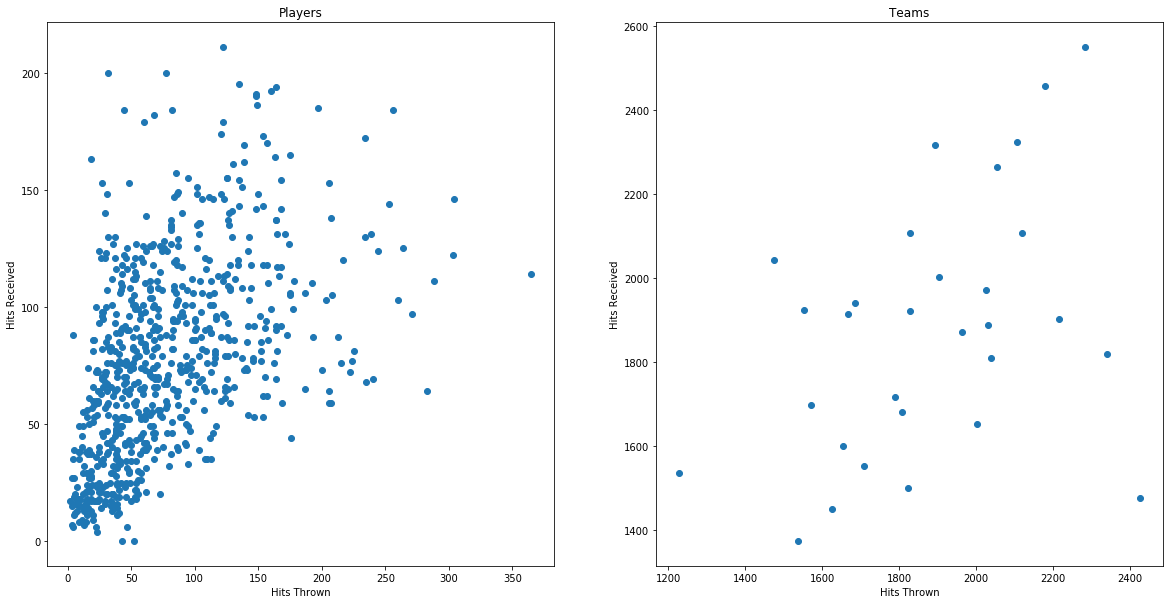

In [27]:
# Is there a correlation between how much players hit and get hit? 
# In other words, do some players hit and get hit a lot and some don't or are teams split into 
# either 'hit a lot' or 'get hit a lot' sides?
plt.figure(figsize = (20, 10))
plt.subplot(1,2,1)
plt.xlabel('Hits Thrown')
plt.ylabel('Hits Received')
plt.scatter(df_players['HitF'], df_players['HitA'])
plt.title('Players')

plt.subplot(1,2,2)
plt.scatter(df_teams['Hit A'], df_teams['Hit F'])
plt.xlabel('Hits Thrown')
plt.ylabel('Hits Received')
plt.title('Teams')

plt.show()

In looking at both charts it seems that any relationship between hits thrown and hits received is weak at best. My thought that perhaps teams and players fell into a 'hit and got hit a lot' or 'not hit and not get hit a lot' bucket are wrong.

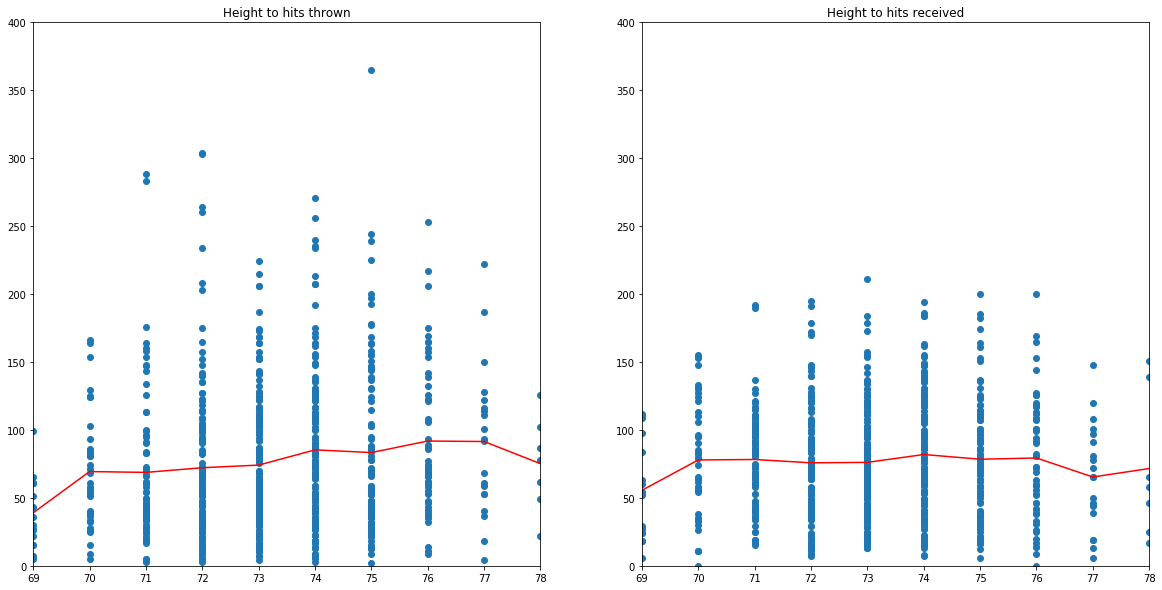

In [28]:
# Since heights are a discreet variable I was able to map each player who fell into that
# particular bucket on a scatterplot that showed their hits thrown and hit received by height.  
plt.figure(figsize = (20, 10))
plt.subplot(1,2,1)
plt.title('Height to hits thrown')
plt.scatter(df_players['HT'], df_players['HitF'])
plt.plot(df_play_HT['HT'], df_play_HT['Hit F'], color = 'r')
plt.xlim(69, 78)
plt.ylim(0,400)

plt.subplot(1,2,2)
plt.title('Height to hits received')
plt.scatter(df_players['HT'], df_players['HitA'])
plt.plot(df_play_HT['HT'], df_play_HT['Hit A'], color = 'r')
plt.xlim(69, 78)
plt.ylim(0,400)

plt.show()

The correlation of team size to hitting is more distinct than player size. From the charts above, however, it seems that while there is a slight relationship to increased height and increased number of hits thrown, hits received is pretty similar across all heights.

In [36]:
# This first dataframe is pulling together goals, points and hits against for all players in 
# the league while the second focuses on the top 40 points scorers (the stars)
df_stars = pd.read_sql_query("Select LastName, G, PTS, HitA From 'Main Page' Where GP >= 10 Order by PTS DESC", cnx)
df_stars_top = pd.read_sql_query("Select LastName, G, PTS, HitA From 'Main Page' Where GP >= 10 Order by PTS DESC Limit 40", cnx)
df_stars.head()

,LastName,G,PTS,HitA
0,Kane,46,106,130
1,Benn,41,89,94
2,Crosby,36,85,117
3,Karlsson,16,82,147
4,Thornton,19,82,63


A follow up to the above question, does the skill level of the player cause them to get hit more. I will look at points rather than goals since a lot of high performing players get just as many points from setting up goals as they do scoring them(for example, Erik Karlson of the Ottawa Senators who plays Defense and yes is in the top 5 in points scoring.)

The question: Do high performing players get hit more than average? 
    --> According to my data, the average player with more than 10 GP played was hit 76.57 times.

The Hypothesis: Common sense would say that yes, a coach is probably telling his guys to be physical with the other teams stars so they don't get comfortable and get a lot of scoring chances.

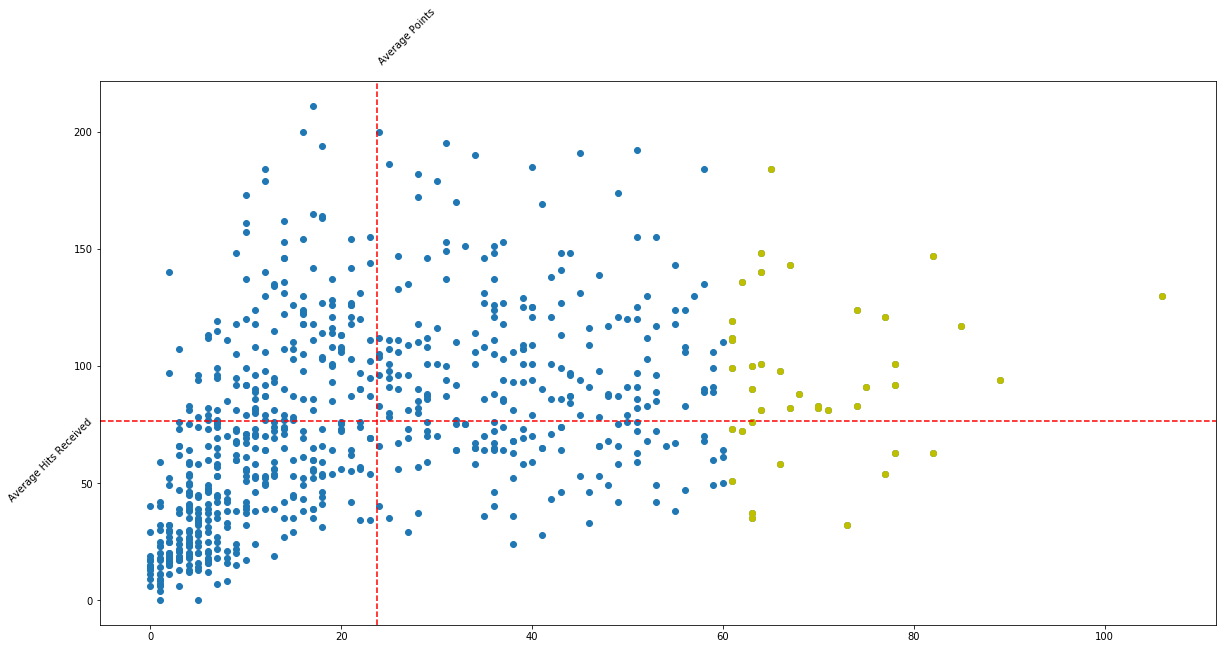

In [10]:
plt.figure(figsize = (20, 10))
plt.scatter(df_stars['PTS'], df_stars['HitA'])
plt.scatter(df_stars_top['PTS'], df_stars_top['HitA'], color ='y')
plt.axhline(df_stars['HitA'].mean(), color = 'r', linestyle = '--')
plt.text(-15, 75, 'Average Hits Received', rotation = 45)
plt.axvline(df_stars['PTS'].mean(), color = 'r', linestyle = '--')
plt.text(df_stars['PTS'].mean(), 250, 'Average Points', rotation = 45)

This scatter plot shows the points scored(x axis) against hits received(y axis) with the averages of both marked with red dashed lines. The top 40 point scorers in the league are marked with a yellow dot instead of blue. Comparing actual numbers you see the following:

Average hits received per player: 76.57
Average hits received by player in top 40: 94.8

<><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><>

Analytical Question 2: In looking at the typical traits of a player who is considered a 'goon', can this quantified?

Hypothesis: I think a typical 'goon' would have a high PIM/Minutes Played ratio, low goals, high hits and possibly a few more.

According to my SQL data, my 'goon' would be based on the following:
    1. Average Goals is 9, a 'goon' would be lower.
    2. Average Penalties in minutes is 31, a 'goon' would be higher.
    3. Average TOI/G is 16, a 'goon' would be lower.
    4. Average HitF is 76, a 'goon' would be higher.

In [37]:
# Building a dataframe based on my criteria for a 'goon'
df_goons = pd.read_sql_query("Select FirstName, LastName, EndTeam, G, PIM, TOIG, HitF from 'Main Page' where G<9 and PIM>31 and TOIG<16 and HitF>76 and GP>10", cnx)
df_goons.head()

,FirstName,LastName,EndTeam,G,PIM,TOIG,HitF
0,Andy,Andreoff,LAK,8,76,8.8,82
1,Brandon,Bollig,CGY,2,103,9.3,117
2,Mark,Borowiecki,OTT,1,107,14.6,271
3,Robert,Bortuzzo,STL,2,52,13.3,93
4,Rene,Bourque,CBJ,3,38,10.4,82


In [12]:
df_goons.head()

,FirstName,LastName,EndTeam,G,PIM,TOIG,HitF
0,Andy,Andreoff,LAK,8,76,8.8,82
1,Brandon,Bollig,CGY,2,103,9.3,117
2,Mark,Borowiecki,OTT,1,107,14.6,271
3,Robert,Bortuzzo,STL,2,52,13.3,93
4,Rene,Bourque,CBJ,3,38,10.4,82


In looking at this list there are a few problems:

    1) There are a lot of people on this list that I would consider 'goons' but there are also several who I would consider your typical grinder(4th line player but not known for dirty play).
    
    2) There are also a few players I belive to be 'goons' who are not on the list, in looking them up the thing that kept them off was the HitF stat. Which makes some sense when I think about one of the main people I noticed was not captured. Steve Ott is not known for throwing big hits but he is a pest and will cheap shot other players and start fights in order to mess with opposing teams.

<><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><>

The third question I will be trying to answer is 'Is there a relationship between the amount of points a teams defense scores(and especially goals) and where they end up in the standings?'

Now, common sense would say that more points(from any player) would help a team out but I'm specifically curious if teams who had a higher percentage of goals/assists coming from defenseman ended up better in the standings than teams with a lower percentage.

One problem I am already running into is that the data is recorded differently for each of the two datasets I am using. The first covering teams tracks total goals scored for that team while the second covering individual players tracks total goals scored by that player but does not separate goals scored while on different teams. Hence in the teams data Washington is listed as scoring 248 goals on the season but in summing the player data Washington has a count of 252 goals meaning a player or players scored goals before or after being traded to/from Washington. There is a column that tracks which teams a player played on however so I could theoretically track down each trade and get the goals total for each dataset to match.

This problem is lessed when you factor in the 10+ games played requirement and brings the discrepancy down to a difference of 3 goals. 

I will need three separate dataframes at least for this, maybe more. The first will have all of the overall team stats from the 15/16 season while the second will focus on total contributions from Defensemen by team and the third will be the exact same as the previous but focusing on forwards. Then I should be able to plot D points against overall rank and find if there is a correlation. I could also compare the top teams in terms of defensive output compared to that teams goals per game, power play and other stats to see if those are affected as well.

In [13]:
#df_TeamDStats is the dataframe containing the summed stats for all of the team's defensemen
df_TeamDStats = pd.read_sql_query("Select EndTeam as 'Team', Sum(G) as 'Goals', Sum(A) as 'Assists', Sum(PTS) as 'Points', Sum(Sh) as 'Shots', Sum(GWG) as 'Game Winning Goals' from 'Main Page' where Pos = 'D' and GP >= 10 group by EndTeam", cnx)

#df_TeamFStats is the dataframe containing the summed stats for all the team's forwards
df_TeamFStats = pd.read_sql_query("Select EndTeam as 'Team', Sum(G) as 'Goals', Sum(A) as 'Assists', Sum(PTS) as 'Points', Sum(Sh) as 'Shots', Sum(GWG) as 'Game Winning Goals' from 'Main Page' where Pos != 'D' and GP >= 10 group by EndTeam", cnx)

#df_TeamStats is the dataframe containing the overall data for each team during the regular season
df_TeamStats = pd.read_sql_query("Select EndRank, Team, W, L, Pts, WinningP, GF, GA, GfpG, PP, ShotsG from 'TeamsData'", cnx)

In [38]:
df_TeamDStats.head()

,Team,Goals,Assists,Points,Shots,Game Winning Goals
0,ANA,37,108,145,708,6
1,ARI,45,102,147,777,11
2,BOS,32,139,171,848,5
3,BUF,28,96,124,607,3
4,CAR,32,93,125,689,7


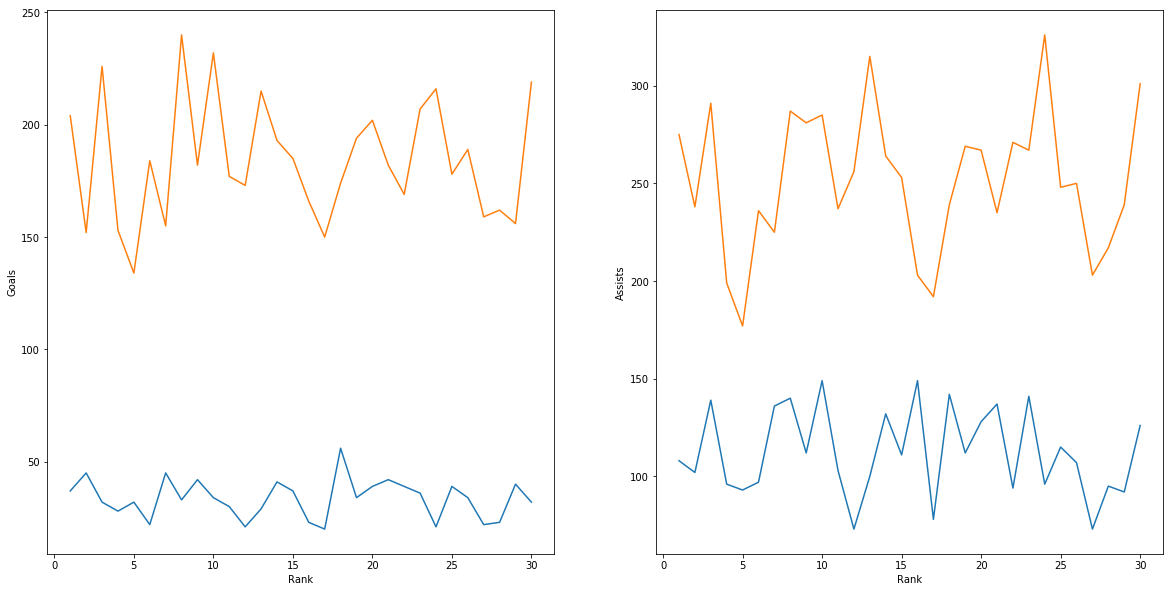

In [14]:
plt.figure(figsize = (20, 10))
plt.subplot(1,2,1)
plt.plot(df_TeamStats['EndRank'], df_TeamDStats['Goals'])
plt.plot(df_TeamStats['EndRank'], df_TeamFStats['Goals'])
plt.xlabel('Rank')
plt.ylabel('Goals')

plt.subplot(1,2,2)
plt.plot(df_TeamStats['EndRank'], df_TeamDStats['Assists'])
plt.plot(df_TeamStats['EndRank'], df_TeamFStats['Assists'])
plt.xlabel('Rank')
plt.ylabel('Assists')
plt.show()

Simply comparing the total Goals and Assists for Defensemen and Forwards against their team rank it is clear that there is no obvious relationship between scoring goals, getting assists and where a team ends up in the standings. This was kind of surprising as I would have thought goals scored would have had a strong connection to team standings. Next I will look at the difference in Goals For and Goals Against as a team falls down the rankings.

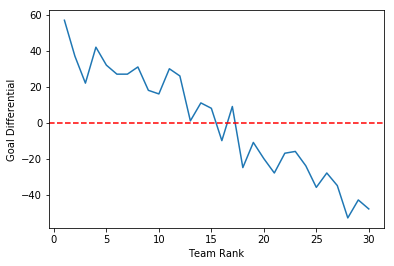

In [15]:
plt.plot(df_TeamStats['EndRank'], (df_TeamStats['GF']-df_TeamStats['GA']))
plt.axhline(0, color = 'r', linestyle = '--')
plt.xlabel('Team Rank')
plt.ylabel('Goal Differential')
plt.show()

As expected, goal diferential has a strong correlation to rank and as a team goes down in rank their goal differential goes into the negatives(more goals scored on them than they scored). So next I would like to see if goal differential was impacted by a teams Defensive goals, aka did teams that got more goal scoring from their defensemen have a better differential?

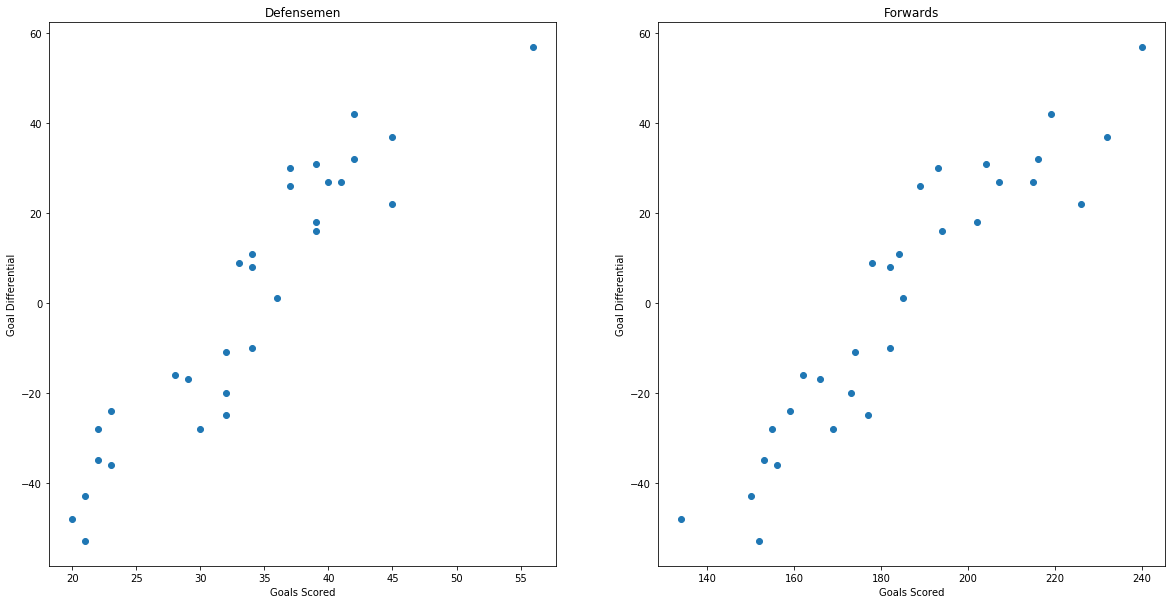

In [51]:
x1 = df_TeamDStats.sort_values(['Goals'], ascending = False)
x2 = df_TeamFStats.sort_values(['Goals'], ascending = False)
y = (df_TeamStats['GF'] - df_TeamStats['GA'])
plt.figure(figsize = (20, 10))

plt.subplot(1,2,1)
plt.scatter(x1['Goals'],y)
plt.title('Defensemen')
plt.ylabel('Goal Differential')
plt.xlabel('Goals Scored')

plt.subplot(1,2,2)
plt.scatter(x2['Goals'], y)
plt.title('Forwards')
plt.ylabel('Goal Differential')
plt.xlabel('Goals Scored')

plt.show()

While the graph on the right is not surprising(a team relies on its forwards for the majority of goals) I was interested in the relatively straight line of points formed by the Defensemen goals indicating at least a relationship if not a causality between the two stats. This is something I would explore more in further research. 

<><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><>

FURTHER RESEARCH

As part of my further research I think the main thing I would like to do start work on a machine learning algorithm that would take individual game data throughout the season and use it to predict outcomes of future games. Part of this would be to monitor such things as how much the defense is contributing compared the the opponents defense. Another factor would be hitting, does team A have a 'star player' that would be a target and does team B have a propensity to hit more than the average team? 

Those and a few other ideas such as a potential 'win booster' for teams that are on a hot streak. This could be as simple as once a team has won 3 games in a row, the algorithm's final output prediction for their next game would have a multiplier applied to it because the team is on a winning streak and hockey is a game of momentum(both literally and figuratively). 